# 시계 multi label classification

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
import random
from PIL import Image

import torch
import torchvision.transforms as T
import timm
from torch.optim.lr_scheduler import StepLR

from sklearn.metrics import f1_score

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device = 'mps'

# data

In [3]:
annotations_df = pd.read_csv('/Users/kimhongseok/cv_79_projects/part1/chapter3/8/data/annotations.csv')
annotations_df

,filename,digit,chronograph,skeleton,jewelry
0,009_cb20cfdd.jpg,0,1,0,0
1,160_fdaf578e.jpg,0,1,0,0
2,133_3096ff30.jpg,0,0,0,0
3,002_10ce6529.jpg,0,1,1,0
4,086_761da09b.jpg,0,1,0,0
...,...,...,...,...,...
619,079_5f66ba04.jpg,0,0,1,0
620,192_96b69d3f.jpg,0,1,1,1
621,169_20ecf901.jpg,0,1,0,1
622,026_3fdbbdc0.jpg,0,0,0,1


# CustomDataset

In [4]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, root_path, annotations_df, transforms):
        super().__init__()
        self.data = []
        self.transforms = transforms

        for i in range(annotations_df.shape[0]):
            img_path = os.path.join(root_path, annotations_df.iloc[i, 0])
            labels = annotations_df.iloc[i, 1:].tolist()

            self.data.append((img_path, labels))

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img = Image.open(self.data[idx][0]).convert('RGB')
        img = self.transforms(img)
        labels = torch.tensor(self.data[idx][1]).float()

        return img, labels

In [5]:
transforms = T.Compose([
    T.Resize((128, 128)),
    T.ToTensor()
])
root_path = '/Users/kimhongseok/cv_79_projects/part1/chapter3/8/data/images'

total_dataset = CustomDataset(root_path, annotations_df, transforms)

In [6]:
total_num = len(total_dataset)
train_num, valid_num, test_num = int(total_num*0.8), int(total_num*0.1), int(total_num*0.1)

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(total_dataset, [train_num+1, valid_num, test_num])

In [7]:
print(len(train_dataset), len(valid_dataset), len(test_dataset))

500 62 62


In [8]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=16, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

# training, evaluation

In [9]:
def training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    total_labels = []
    total_preds = []

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        preds = (torch.sigmoid(outputs) > threshold).float()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss /= len(train_dataloader)
    train_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, train_loss, train_f1

def evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    total_labels = []
    total_preds = []

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            preds = (torch.sigmoid(outputs) > threshold).float()

            valid_loss += loss.item()
            total_labels.extend(labels.cpu().numpy())
            total_preds.extend(preds.cpu().numpy())

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss /= len(valid_dataloader)
    valid_f1 = f1_score(total_labels, total_preds, average='macro')

    return model, valid_loss, valid_f1

def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, threshold, num_epochs):
    model.to(device)
    
    for epoch in range(num_epochs):
        model, train_loss, train_f1 = training(model, train_dataloader, criterion, optimizer, threshold, epoch, num_epochs)
        model, valid_loss, valid_f1 = evaluation(model, valid_dataloader, criterion, threshold, epoch, num_epochs)

        print(f'Train Loss: {train_loss}, Train F1: {train_f1}, Valid Loss: {valid_loss}, Valid F1: {valid_f1}')

    return model

# model

In [10]:
model = timm.create_model(
    'efficientnet_b4',
    pretrained=True,
    num_classes=4
)
model

EfficientNet(
  (conv_stem): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (bn1): BatchNormAct2d(
    48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
    (drop): Identity()
    (act): SiLU(inplace=True)
  )
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNormAct2d(
          48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
          (drop): Identity()
          (act): SiLU(inplace=True)
        )
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNormAct2d(
    

In [12]:
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

model = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, 0.5, 50)

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.5923715559765697, Train F1: 0.2541060945407461, Valid Loss: 0.5698260590434074, Valid F1: 0.296551724137931


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.22828343510627747, Train F1: 0.7187019921237839, Valid Loss: 0.471428781747818, Valid F1: 0.27261663286004056


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.13054287934210151, Train F1: 0.8595608339029392, Valid Loss: 0.4726342186331749, Valid F1: 0.31574074074074077


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.06644415884511545, Train F1: 0.9463753683291497, Valid Loss: 0.5375953167676926, Valid F1: 0.3477124183006536


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0574454459710978, Train F1: 0.9395569772687877, Valid Loss: 0.5328869074583054, Valid F1: 0.300595238095238


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.07427751601790078, Train F1: 0.9556653499295721, Valid Loss: 0.5325521677732468, Valid F1: 0.3570230607966457


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0740760643966496, Train F1: 0.9410236683007502, Valid Loss: 0.5399273186922073, Valid F1: 0.3380688124306326


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0774905621947255, Train F1: 0.9296940334658929, Valid Loss: 0.5242574214935303, Valid F1: 0.31342592592592594


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.05428285870584659, Train F1: 0.9556010036318439, Valid Loss: 0.5611070245504379, Valid F1: 0.446001221001221


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.05181841174635338, Train F1: 0.9625580883370278, Valid Loss: 0.517464391887188, Valid F1: 0.30092592592592593


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.06246630549139809, Train F1: 0.9464906850464129, Valid Loss: 0.763207271695137, Valid F1: 0.4759803921568627


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.07649995618703542, Train F1: 0.9374315707413189, Valid Loss: 0.6900122612714767, Valid F1: 0.36329787234042554


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.055263376474613324, Train F1: 0.9504859270251061, Valid Loss: 0.6107136905193329, Valid F1: 0.3469212246302029


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0568944017868489, Train F1: 0.9522938671429041, Valid Loss: 0.5741826593875885, Valid F1: 0.3375786163522012


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.06751110121331294, Train F1: 0.9579167116339303, Valid Loss: 0.5274218618869781, Valid F1: 0.35563909774436087


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.056265021456056274, Train F1: 0.9526593323896723, Valid Loss: 0.6104743778705597, Valid F1: 0.3406905594405594


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.04036247528711101, Train F1: 0.9660358438900594, Valid Loss: 0.4719420522451401, Valid F1: 0.4103105356975326


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.03224906990362797, Train F1: 0.9770685224799586, Valid Loss: 0.4751788377761841, Valid F1: 0.3958110516934046


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.02600359729694901, Train F1: 0.9702135178286921, Valid Loss: 0.4475228413939476, Valid F1: 0.4479755178907721


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.01674424664088292, Train F1: 0.9812171653919365, Valid Loss: 0.41806988418102264, Valid F1: 0.3844086021505376


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.023264394768375496, Train F1: 0.9788189611741642, Valid Loss: 0.520201250910759, Valid F1: 0.536111111111111


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.021453718460179516, Train F1: 0.9767634484660483, Valid Loss: 0.5436828881502151, Valid F1: 0.36455108359133126


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.018403120043331, Train F1: 0.9784590923218697, Valid Loss: 0.6235150694847107, Valid F1: 0.3333333333333333


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.012003590175481804, Train F1: 0.9846644370310853, Valid Loss: 0.7427158504724503, Valid F1: 0.3733516483516483


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.020447143758246966, Train F1: 0.9854601862241931, Valid Loss: 0.6615415886044502, Valid F1: 0.28866525423728817


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.02484167758939293, Train F1: 0.9784867031097236, Valid Loss: 0.8990490585565567, Valid F1: 0.38478991596638656


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.05502561549656093, Train F1: 0.9616796509554993, Valid Loss: 0.6728377789258957, Valid F1: 0.3691919191919192


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.07985287812698516, Train F1: 0.940928469284397, Valid Loss: 0.7123195081949234, Valid F1: 0.21362229102167182


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.07465034199412912, Train F1: 0.9096397872415259, Valid Loss: 0.6053179502487183, Valid F1: 0.3283898305084746


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.03447171440348029, Train F1: 0.9700483222079488, Valid Loss: 0.6941084861755371, Valid F1: 0.3507352941176471


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0369665226280631, Train F1: 0.9616395086319898, Valid Loss: 0.6296426951885223, Valid F1: 0.34523809523809523


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.03550288918995648, Train F1: 0.9689350334316008, Valid Loss: 0.6161097288131714, Valid F1: 0.3533834586466166


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.0357797028227651, Train F1: 0.965327264215644, Valid Loss: 0.5438016057014465, Valid F1: 0.3759109311740891


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.03729898871824844, Train F1: 0.9499551889831216, Valid Loss: 0.6236173361539841, Valid F1: 0.335609243697479


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.02734347765908751, Train F1: 0.9698396807235481, Valid Loss: 0.5910543948411942, Valid F1: 0.503030303030303


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.017800322582843364, Train F1: 0.9795675815412657, Valid Loss: 0.6504500657320023, Valid F1: 0.3294172932330828


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.01409333504307142, Train F1: 0.988169985462431, Valid Loss: 0.671847864985466, Valid F1: 0.43884853376378796


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.010494289242615196, Train F1: 0.984055088846396, Valid Loss: 0.6274418979883194, Valid F1: 0.49702380952380953


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.010167352185817435, Train F1: 0.9855709809514158, Valid Loss: 0.6929012835025787, Valid F1: 0.33329297820823245


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.01145807521243114, Train F1: 0.9867634602303734, Valid Loss: 0.6310003995895386, Valid F1: 0.2901785714285714


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.023466128268410102, Train F1: 0.9825493877616849, Valid Loss: 0.5939201414585114, Valid F1: 0.25555555555555554


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.024139963019024435, Train F1: 0.9670380621508231, Valid Loss: 0.6467383503913879, Valid F1: 0.2785310734463277


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.01952403018640325, Train F1: 0.9737190308769863, Valid Loss: 0.487729050219059, Valid F1: 0.4422814207650273


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.009331312197900843, Train F1: 0.9858501653141394, Valid Loss: 0.4793090745806694, Valid F1: 0.3706879361914257


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.020077587263585883, Train F1: 0.975536316630916, Valid Loss: 0.531051903963089, Valid F1: 0.3902777777777777


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.026862209405408066, Train F1: 0.972031454334403, Valid Loss: 0.6480966359376907, Valid F1: 0.32675438596491235


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.019010883075679885, Train F1: 0.9797054969409618, Valid Loss: 0.8090091794729233, Valid F1: 0.3628473744192162


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.026987045011082955, Train F1: 0.9875499891353107, Valid Loss: 0.7599865645170212, Valid F1: 0.4239766081871345


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.04350794032961858, Train F1: 0.9575455400737956, Valid Loss: 0.618818998336792, Valid F1: 0.30833333333333335


  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Train Loss: 0.02581245488181594, Train F1: 0.9730530464523266, Valid Loss: 0.5555840954184532, Valid F1: 0.5371299198885405


# test

In [13]:
model.eval()
total_preds = []
total_labels = []

with torch.no_grad():
    tbar = tqdm(test_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = (torch.sigmoid(outputs)>0.5).float()

        total_labels.extend(labels.cpu().numpy())
        total_preds.extend(preds.cpu().numpy())

print(f1_score(total_labels, total_preds, average='macro'))

  0%|          | 0/4 [00:00<?, ?it/s]

0.5239348370927318


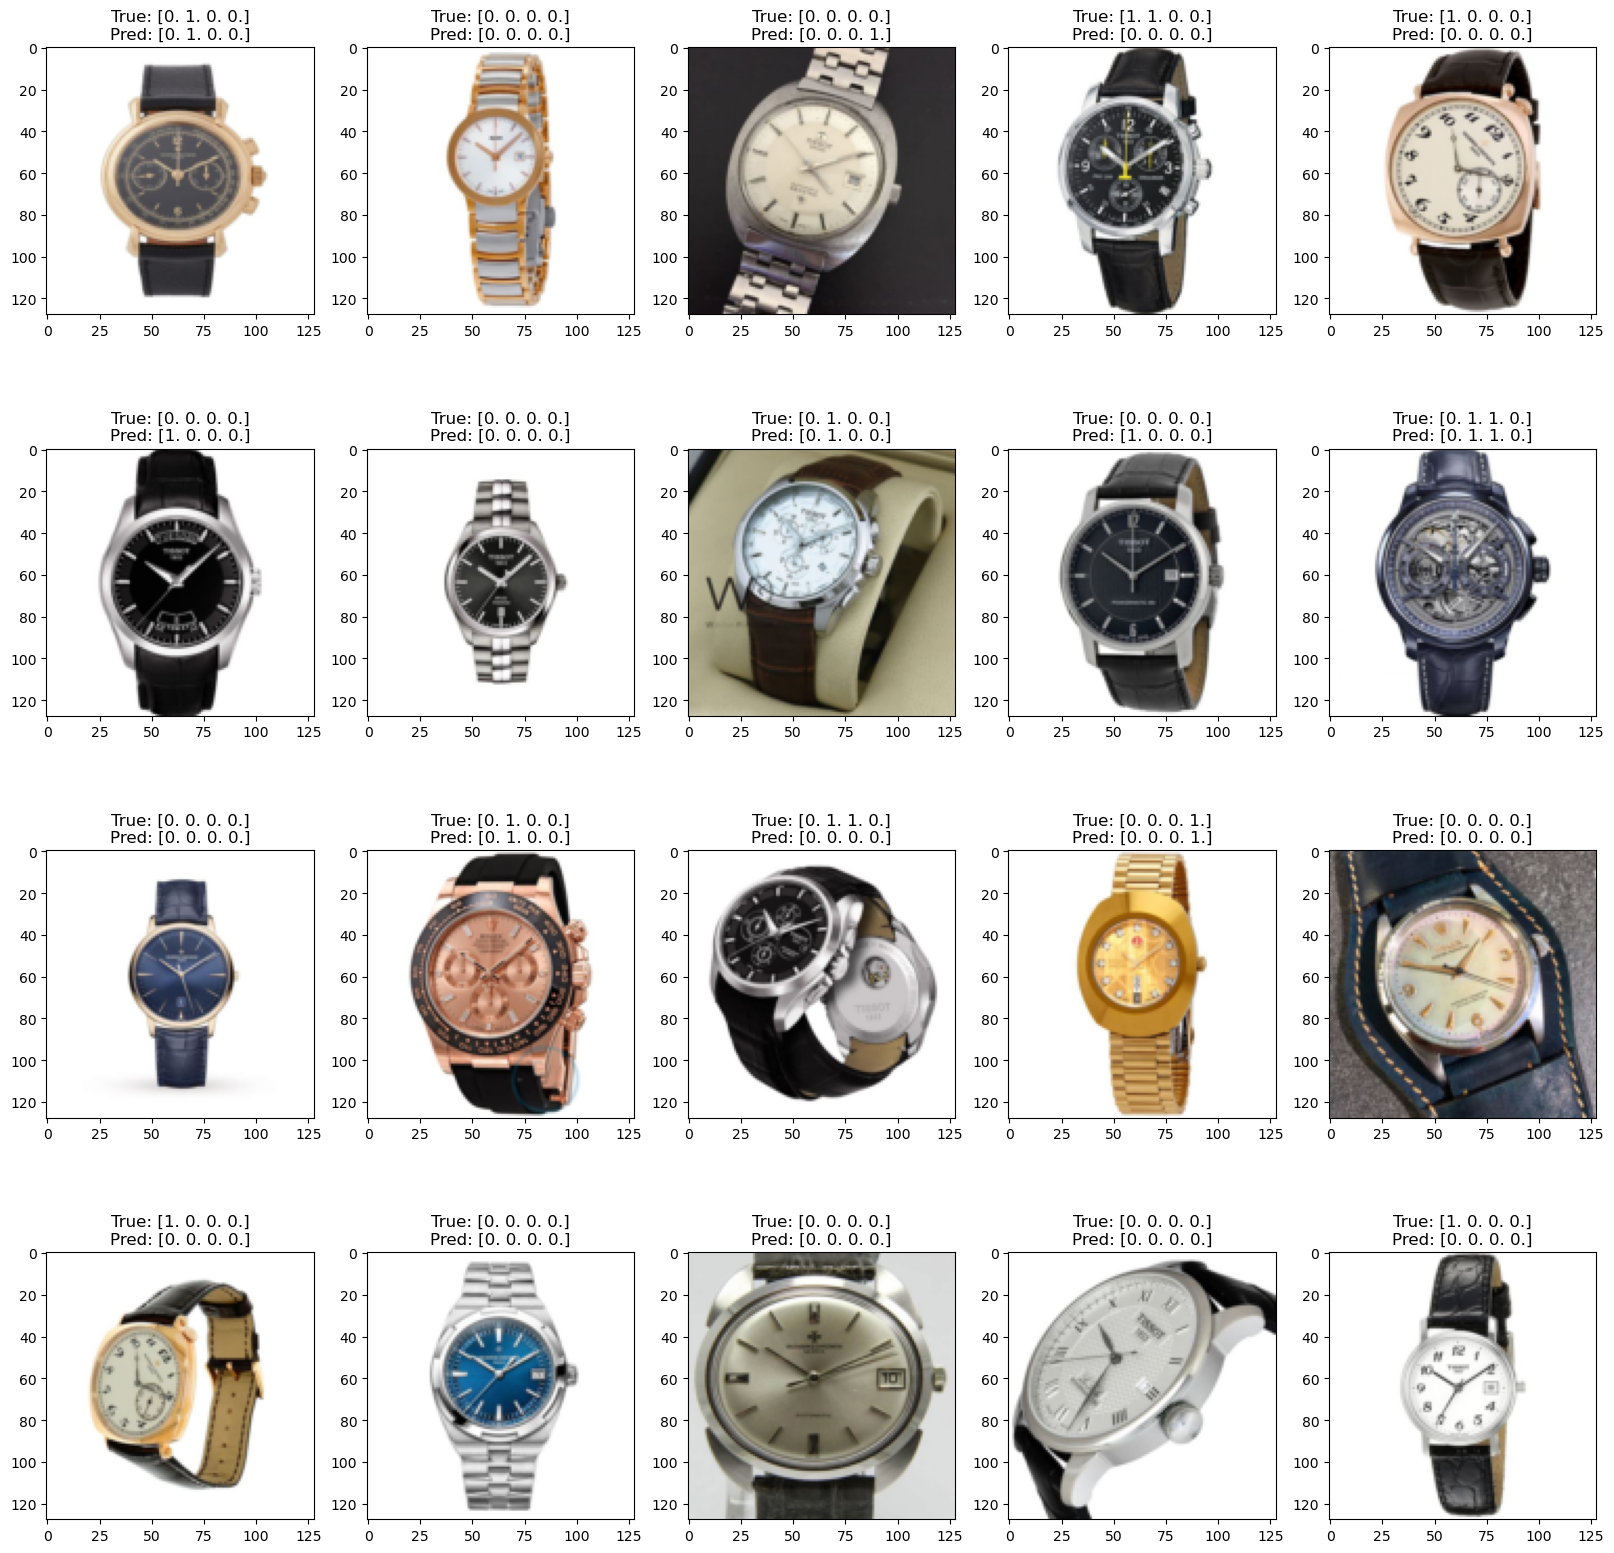

In [14]:
plt.figure(figsize=(20, 20))
for i in range(20):
    ax = plt.subplot(4, 5, i+1)
    plt.imshow(test_dataset[i][0].permute(1, 2, 0))
    plt.title(f'True: {total_labels[i]}\nPred: {total_preds[i]}')